In [1]:
import glob
import tensorflow as tf
import os
import pandas as pd
import subprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_path = "/Users/paulinha/Images"
retrain_script_path = "/Users/paulinha/Images/retrain.py"

In [3]:
image_folders = os.listdir(data_path)
print("I have {} folders of images".format(len(image_folders)))
image_folders

I have 38 folders of images


['parking_space',
 'forest',
 'christmas_tree_farm',
 'tennis_court',
 'solar_panel',
 'basketball_court',
 'coastal_mansion',
 'river',
 'storage_tank',
 'nursing_home',
 'harbor',
 'oil_well',
 'ferry_terminal',
 'golf_course',
 'runway',
 'bridge',
 'oil_gas_field',
 'mobile_home_park',
 'overpass',
 'chaparral',
 'railway',
 'cemetery',
 'wastewater_treatment_plant',
 'baseball_field',
 'runway_marking',
 'intersection',
 'shipping_yard',
 'swimming_pool',
 'airplane',
 'sparse_residential',
 'parking_lot',
 'football_field',
 'beach',
 'dense_residential',
 'freeway',
 'crosswalk',
 'closed_road',
 'transformer_station']

In [4]:
print("Each folder has approximately {} images".format(len(os.path.join(data_path, image_folders[0]))))

Each folder has approximately 63 images


Lets plot one of the images

/Users/robincole/Documents/Data/PatternNet/Images/sparse_residential/sparseresidential345.jpg
(256, 256, 3)


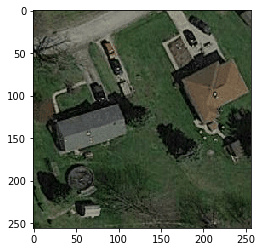

In [5]:
img_path = glob.glob(data_path + '/sparse_residential/*', recursive=True)[0]
print(img_path)
img = plt.imread(img_path)
print(img.shape)
plt.imshow(img);

## Perform the transfer learning with Inception V3 

The `retrain.py` script will take care of splitting data into test/train/validate. Execute retrain with the following:

In [6]:
run_command_str = "python3 {} --image_dir {}".format(retrain_script_path, data_path)
print(run_command_str)

python3 /Users/robincole/Documents/Github/tensorflow-hub/examples/image_retraining/retrain.py --image_dir /Users/robincole/Documents/Data/PatternNet/Images


## Evaluate training



In [8]:
train_accuracy = pd.read_csv("../resources/run_train-tag-accuracy_1.csv")

In [9]:
validation_accuracy = pd.read_csv("../resources/run_validation-tag-accuracy_1.csv")

Validation accuracy is about 96%

In [11]:
model_path = "/Users/paulinha/Image/inception_v3/output_graph.pb"
file_size = int(os.stat(model_path).st_size/1e6)
print("The generated model (`.pb`) file is {} MB".format(file_size))

The generated model (`.pb`) file is 87 MB


In [12]:
labels_path = "/Users/paulinha/Image/inception_v3/output_labels.txt"
labels = []
with open(labels_path) as f:
    for line in f:
        labels.append(line.strip('\n'))

print("The number of labels is {} and we expected {}".format(len(labels), len(image_folders)))

The number of labels is 38 and we expected 38


In [13]:
poets_folder = "/Users/paulinha/Image/tensorflow-for-poets-2/scripts"
os.listdir(poets_folder)

['graph_pb2tb.py',
 'quantize_graph.py',
 'retrain.py',
 'label_image.py',
 '__init__.py',
 'show_image.py',
 'evaluate.py',
 'count_ops.py']

Lets first pass one of the images used during training. The command we require is:

In [14]:
"python3 {} --image={} --graph={} --labels={} --input_layer=Placeholder --output_layer=final_result".format("label_image.py", img_path, model_path, labels_path) #  --output_layer=final_result:0

'python3 label_image.py --image=/Users/robincole/Documents/Data/PatternNet/Images/forest/forest083.jpg --graph=/Users/robincole/Documents/Data/PatternNet/inception_v3/output_graph.pb --labels=/Users/robincole/Documents/Data/PatternNet/inception_v3/output_labels.txt --input_layer=Placeholder --output_layer=final_result'

Response is:
```
forest 0.9981623
river 0.00075750035
sparse residential 0.00010027897
oil gas field 8.9558e-05
railway 8.550265e-05
```

NOTE I changed the image used to include a residential

In [17]:
run_command_str = "python3 {} --image_dir {} --tfhub_module https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/1".format(retrain_script_path, data_path)
print(run_command_str)

python3 /Users/robincole/Documents/Github/tensorflow-hub/examples/image_retraining/retrain.py --image_dir /Users/robincole/Documents/Data/PatternNet/Images --tfhub_module https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/1


Validation accuracy at 97%

Since the mobilenet model is small (> 10 MB) we can uplodad it to Github 

In [5]:
model_path = "mobilenet_v2/output_graph.pb"
file_size = int(os.stat(model_path).st_size/1e6)
print("The generated model (`.pb`) file is {} MB".format(file_size))

The generated model (`.pb`) file is 9 MB


In [57]:
label_file = "mobilenet_v2/output_labels.txt"

Lets make a prediction directly with this model:

In [46]:
from label_image import load_graph, load_labels, read_tensor_from_image_file

In [22]:
graph = load_graph(model_path)

In [50]:
input_height = 224
input_width = 224
t = read_tensor_from_image_file(img_path, input_height=input_height, input_width=input_width)  # Return the reshaped image

In [51]:
t.shape

(1, 224, 224, 3)

In [72]:
input_operation = graph.get_operation_by_name("import/Placeholder")
output_operation = graph.get_operation_by_name("import/final_result")

In [62]:
with tf.Session(graph=graph) as sess:
    results = sess.run(output_operation.outputs[0], {
        input_operation.outputs[0]: t
    })
results = np.squeeze(results)

top_k = results.argsort()[-5:][::-1]
labels = load_labels(label_file)

for i in top_k:
    print(labels[i], results[i])

sparse residential 0.91276056
coastal mansion 0.04089476
dense residential 0.023936834
swimming pool 0.011247711
nursing home 0.005313007


Lets put the data in a common format used by ResNet etc.

In [69]:
data = {}
data["predictions"] = []

for i in top_k:
    r = {"label": labels[i], "probability": round(results[i], 5)}
    data["predictions"].append(r)
data["success"] = True

data

{'predictions': [{'label': 'sparse residential', 'probability': 0.91276},
  {'label': 'coastal mansion', 'probability': 0.04089},
  {'label': 'dense residential', 'probability': 0.02394},
  {'label': 'swimming pool', 'probability': 0.01125},
  {'label': 'nursing home', 'probability': 0.00531}],
 'success': True}